# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn import set_config

from statsmodels.stats.outliers_influence import variance_inflation_factor

from typing import Optional, List, Dict
import warnings

from ml.utils.utils import (
    get_data,
    remove_outliers,
    numerical_categorical_analysis,
    anova_test,
    two_sample_independent_ttest,
)

%matplotlib inline

In [2]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) 

# Enable pandas output for the pipeline
set_config(transform_output="pandas")

## Ignore warnings
warnings.filterwarnings("ignore")

## Read the Data

In [3]:
df = get_data("smartphone_cleaned_v2", "processed")
final_df = remove_outliers(df).drop(columns = ["model"])
final_df.head()

,price,rating,os,brand_name,has_5g,has_nfc,has_ir_blaster,num_cores,processor_speed,processor_brand,ram_capacity,internal_memory,battery_capacity,fast_charging,screen_size,resolution,refresh_rate,num_rear_cameras,num_front_cameras,primary_camera_rear,primary_camera_front,fast_charging_available,extended_memory_available,extended_upto
0,54999,89.0,android,oneplus,True,True,False,8.0,3.2,snapdragon,12.0,256.0,5000.0,100.0,6.70,1440 x 3216,120,3,1,50,16.0,1,0,0.0
1,19989,81.0,android,oneplus,True,False,False,8.0,2.2,snapdragon,6.0,128.0,5000.0,33.0,6.59,1080 x 2412,120,3,1,64,16.0,1,1,1024.0
2,16499,75.0,android,samsung,True,False,False,8.0,2.4,exynos,4.0,64.0,5000.0,15.0,6.60,1080 x 2408,90,3,1,50,13.0,1,1,1024.0
3,14999,81.0,android,motorola,True,False,False,8.0,2.2,snapdragon,6.0,128.0,5000.0,NaN,6.55,1080 x 2400,120,3,1,50,16.0,1,1,1024.0
4,24999,82.0,android,realme,True,False,False,8.0,2.6,dimensity,6.0,128.0,5000.0,67.0,6.70,1080 x 2412,120,3,1,108,16.0,1,0,0.0


In [4]:
final_df.shape

(942, 24)

In [5]:
change_to_categorical = [
    "extended_upto", "primary_camera_front", "primary_camera_rear", 
    "num_rear_cameras", "num_front_cameras", "refresh_rate", 
    "ram_capacity", "num_cores", "extended_upto", "internal_memory",
    "fast_charging", "fast_charging_available", "extended_memory_available"
]

# Convert columns to categorical using assign
final_df = final_df.assign(**{col: final_df[col].astype('object') for col in change_to_categorical})

In [6]:
cat_cols = final_df.select_dtypes(include=['object', 'bool']).columns.tolist()
cat_cols = [col for col in cat_cols if col != 'model']

num_cols = [col for col in final_df.columns.tolist() if col not in cat_cols and col not in ["rating", "model"]]


## Train Test Split

In [7]:
X = final_df.dropna(subset=["rating"]).drop(columns='rating')
y = final_df['rating'].dropna()


In [8]:
y.head()

0    89.0
1    81.0
2    75.0
3    81.0
4    82.0
Name: rating, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [10]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (685, 23)
The shape of test data is (172, 23)


## Data Preprocessing 

### Imputation Pipeline

In [11]:
class DropNA(BaseEstimator, TransformerMixin):
    """
    A transformer that drops rows with missing values (NaN) from a Pandas DataFrame.

    :param subset: List of columns to consider when dropping rows with NaN values.
                   If None, all columns are considered.
    :type subset: Optional[List[str]], optional

    Attributes
    ----------
    subset : Optional[List[str]]
        List of columns to consider when dropping rows with NaN values.
    """
    def __init__(self, subset: Optional[List[str]] = None):
        self.subset = subset

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "DropNA":
        """
        Fit the transformer. This method does not actually perform any computation.

        :param X: The input DataFrame.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: DropNA
        """
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Drop rows with missing values (NaN) from the input DataFrame.

        :param X: The input DataFrame.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with rows containing NaN values in the specified subset of columns removed.
        :rtype: pd.DataFrame
        """
        return X.dropna(subset=self.subset)

In [12]:
class ProcessorBrandImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'processor_brand' values in a DataFrame based on the 'brand_name'.

    This transformer learns the most frequent 'processor_brand' for each 'brand_name'
    during the `fit` method and uses this information to impute missing values
    during the `transform` method. Handles cases where a brand has no associated
    processor brand in the training data, or where a specific brand ('ikall' or 'tesla')
    should always have an 'Unknown' processor.

    Attributes
    ----------
    brand_processor_mode : Dict[str, str]
        A dictionary mapping 'brand_name' to the most frequent 'processor_brand'.
        Stores the mode for each brand name learned during the fit step.
    """
    def __init__(self):
        self.brand_processor_mode: Optional[Dict[str, str]] = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "ProcessorBrandImputer":
        """
        Learns the most frequent 'processor_brand' for each 'brand_name'.

        Calculates the mode of 'processor_brand' for each 'brand_name' present
        in the input DataFrame `X` and stores it in `self.brand_processor_mode`.

        :param X: The input DataFrame containing 'brand_name' and 'processor_brand' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: ProcessorBrandImputer
        """
        self.brand_processor_mode = (
            X[X['processor_brand'].notnull()]
            .groupby('brand_name')['processor_brand']
            .agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
            .to_dict()
        )
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'processor_brand' values in the input DataFrame.

        Uses the learned `self.brand_processor_mode` to fill missing
        'processor_brand' values. If a 'brand_name' is not found in the
        learned mapping, 'Unknown' is used as the imputation value. Also handles
        special cases where 'ikall' and 'tesla' brands are always assigned
        the 'Unknown' processor.

        :param X: The input DataFrame containing 'brand_name' and 'processor_brand' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with missing 'processor_brand' values imputed.
        :rtype: pd.DataFrame
        """
        def impute_processor(row):
            if row['brand_name'] in ['ikall', 'tesla']:
                return 'Unknown'
            elif pd.isnull(row['processor_brand']):
                return self.brand_processor_mode.get(row['brand_name'], 'Unknown')
            return row['processor_brand']

        X['processor_brand'] = X.apply(impute_processor, axis=1)
        return X

In [13]:
class BatteryCapacityImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'battery_capacity' values with the median battery capacity
    of Apple devices.

    This transformer calculates the median 'battery_capacity' for devices where
    'brand_name' (case-insensitive) is 'apple' during the `fit` method and uses
    this median to fill missing 'battery_capacity' values during the `transform`
    method.

    Attributes
    ----------
    apple_median : Optional[float]
        The median battery capacity of Apple devices.
    """
    def __init__(self):
        self.apple_median: Optional[float] = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "BatteryCapacityImputer":
        """
        Calculates the median battery capacity for Apple devices.

        :param X: The input DataFrame containing 'brand_name' and 'battery_capacity' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: BatteryCapacityImputer
        """
        self.apple_median = X.loc[X['brand_name'].str.lower() == 'apple', 'battery_capacity'].median()
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'battery_capacity' values with the calculated median.

        :param X: The input DataFrame containing 'battery_capacity' column.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with missing 'battery_capacity' values imputed.
        :rtype: pd.DataFrame
        """
        X['battery_capacity'] = X['battery_capacity'].fillna(self.apple_median)
        return X


class ExtendedUptoImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'extended_upto' values with the median 'extended_upto' value
    for devices where 'extended_memory_available' is 1.

    Attributes
    ----------
    extended_memory_median : Optional[float]
        The median 'extended_upto' value for devices with extended memory available.
    """
    def __init__(self):
        self.extended_memory_median: Optional[float] = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "ExtendedUptoImputer":
        """
        Calculates the median 'extended_upto' value for devices with extended memory.

        :param X: The input DataFrame containing 'extended_memory_available' and 'extended_upto' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: ExtendedUptoImputer
        """
        self.extended_memory_median = X.loc[X['extended_memory_available'] == 1, 'extended_upto'].median()
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'extended_upto' values.

        :param X: The input DataFrame containing 'extended_upto' column.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with missing 'extended_upto' values imputed.
        :rtype: pd.DataFrame
        """
        X['extended_upto'] = X.apply(
            lambda row: row['extended_upto'] if pd.notnull(row['extended_upto'])
            else self.extended_memory_median,
            axis=1
        )
        return X


class FastChargingImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'fast_charging' values to 0 when 'fast_charging_available' is 0.
    """
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "FastChargingImputer":
        """
        Fit the transformer. This method does not actually perform any computation.

        :param X: The input DataFrame.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: FastChargingImputer
        """
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes 'fast_charging' values.

        Sets 'fast_charging' to 0 if 'fast_charging_available' is 0 and 'fast_charging' is NaN.

        :param X: The input DataFrame containing 'fast_charging' and 'fast_charging_available' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'fast_charging' values.
        :rtype: pd.DataFrame
        """
        X['fast_charging'] = X.apply(
            lambda row: 0 if row['fast_charging_available'] == 0 and pd.isnull(row['fast_charging'])
            else row['fast_charging'],
            axis=1
        )
        return X

In [14]:
class ConsistentBrandsImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'fast_charging' values for specific brands with their medians.

    This transformer calculates the median 'fast_charging' value for a predefined
    list of brands ('lg', 'oneplus', 'xiaomi', 'vivo') during the `fit` method.
    It then uses these medians to impute missing 'fast_charging' values for the
    respective brands during the `transform` method.

    Attributes
    ----------
    brand_medians : Dict[str, Optional[float]]
        A dictionary storing the median 'fast_charging' value for each
        consistent brand.
    """
    def __init__(self):
        self.brand_medians: Dict[str, Optional[float]] = {}  # Store median fast_charging for each brand

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "ConsistentBrandsImputer":
        """
        Calculates the median 'fast_charging' for consistent brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: ConsistentBrandsImputer
        """
        consistent_brands = ['lg', 'oneplus', 'xiaomi', 'vivo']
        for brand in consistent_brands:
            median_value = X.loc[X['brand_name'].str.lower() == brand, 'fast_charging'].median()
            self.brand_medians[brand] = median_value
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'fast_charging' values for consistent brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'fast_charging' values for consistent brands.
        :rtype: pd.DataFrame
        """
        for brand, median_value in self.brand_medians.items():
            X.loc[
                (X['brand_name'].str.lower() == brand) & (X['fast_charging'].isnull()),
                'fast_charging'
            ] = median_value
        return X

In [15]:
class HigherMissingBrandsImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'fast_charging' values for specific brands with their medians.

    This transformer calculates the median 'fast_charging' value for a predefined
    list of brands ('samsung', 'apple') during the `fit` method. It then uses
    these medians to impute missing 'fast_charging' values for the respective
    brands during the `transform` method.

    Attributes
    ----------
    brand_medians : Dict[str, Optional[float]]
        A dictionary storing the median 'fast_charging' value for each
        specified brand.
    """
    def __init__(self):
        self.brand_medians: Dict[str, Optional[float]] = {}

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "HigherMissingBrandsImputer":
        """
        Calculates the median 'fast_charging' for specified brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: HigherMissingBrandsImputer
        """
        higher_missing_brands = ['samsung', 'apple']
        for brand in higher_missing_brands:
            median_value = X.loc[X['brand_name'].str.lower() == brand, 'fast_charging'].median()
            self.brand_medians[brand] = median_value
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'fast_charging' values for specified brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'fast_charging' values for specified brands.
        :rtype: pd.DataFrame
        """
        for brand, median_value in self.brand_medians.items():
            X.loc[
                (X['brand_name'].str.lower() == brand) & (X['fast_charging'].isnull()),
                'fast_charging'
            ] = median_value
        return X

In [16]:
class LowerMissingBrandsImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'fast_charging' values for specific brands with their medians.

    This transformer calculates the median 'fast_charging' value for a predefined
    list of brands ('sony', 'xiaomi', 'oppo', 'motorola', 'google') during the
    `fit` method. It then uses these medians to impute missing 'fast_charging'
    values for the respective brands during the `transform` method.

    Attributes
    ----------
    brand_medians : Dict[str, Optional[float]]
        A dictionary storing the median 'fast_charging' value for each
        specified brand.
    """
    def __init__(self):
        self.brand_medians: Dict[str, Optional[float]] = {}

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "LowerMissingBrandsImputer":  
        """
        Calculates the median 'fast_charging' for specified brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: LowerMissingBrandsImputer 
        """
        lower_missing_brands = ['sony', 'xiaomi', 'oppo', 'motorola', 'google']
        for brand in lower_missing_brands:
            median_value = X.loc[X['brand_name'].str.lower() == brand, 'fast_charging'].median()
            self.brand_medians[brand] = median_value
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'fast_charging' values for specified brands.

        :param X: The input DataFrame containing 'brand_name' and 'fast_charging' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'fast_charging' values for specified brands.
        :rtype: pd.DataFrame
        """
        for brand, median_value in self.brand_medians.items():
            X.loc[
                (X['brand_name'].str.lower() == brand) & (X['fast_charging'].isnull()),
                'fast_charging'
            ] = median_value
        return X

In [17]:
class SingleRecordBrandsRemover(BaseEstimator, TransformerMixin):
    """
    Removes records associated with specific brands from a DataFrame.

    This transformer removes rows where the 'brand_name' (case-insensitive) is
    present in a predefined or user-provided list of brands.

    Attributes
    ----------
    brands_to_remove : List[str], default=['blu', 'leitz', 'sharp']
        A list of brand names to remove from the DataFrame.
    """
    def __init__(self, brands_to_remove: Optional[List[str]] = None):
        self.brands_to_remove = brands_to_remove or ['blu', 'leitz', 'sharp']  # Default brands

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "SingleRecordBrandsRemover":
        """
        Fit the transformer. This method does not actually perform any computation.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame.
        y : Optional[pd.Series], default=None
            Ignored. Present here for compatibility with the scikit-learn API.

        Returns
        -------
        self : SingleRecordBrandsRemover
            Returns self.
        """
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Removes records associated with the specified brands.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame containing the 'brand_name' column.
        y : Optional[pd.Series], default=None
            Ignored. Present here for compatibility with the scikit-learn API.

        Returns
        -------
        pd.DataFrame
            The DataFrame with records associated with the specified brands removed.
        """
        return X[~X['brand_name'].str.lower().isin(self.brands_to_remove)]

In [18]:
class OSByBrandImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing 'os' values based on the mode 'os' for each 'brand_name'.

    This transformer calculates the mode of the 'os' column for each
    'brand_name' during the `fit` method and uses these modes to impute
    missing 'os' values during the `transform` method.

    Attributes
    ----------
    os_mode : Dict[str, Optional[str]]
        A dictionary mapping each 'brand_name' to its most frequent 'os' value.
        Can be None if fit has not been called.
    """
    def __init__(self):
        self.os_mode: Optional[Dict[str, Optional[str]]] = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "OSByBrandImputer":  # String literal
        """
        Calculates the mode 'os' for each 'brand_name'.

        :param X: The input DataFrame containing 'brand_name' and 'os' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: Returns self.
        :rtype: OSByBrandImputer
        """
        self.os_mode = X.groupby('brand_name')['os'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
        return self

    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Imputes missing 'os' values based on the calculated modes.

        :param X: The input DataFrame containing 'brand_name' and 'os' columns.
        :type X: pd.DataFrame
        :param y: Ignored. Present here for compatibility with the scikit-learn API.
        :type y: Optional[pd.Series], optional
        :return: The DataFrame with imputed 'os' values.
        :rtype: pd.DataFrame
        """
        X['os'] = X.apply(
            lambda row: self.os_mode.get(row['brand_name']) if pd.isnull(row['os']) else row['os'], axis=1
        )
        return X

In [19]:
# Handle missing values pipeline
missing_handler = Pipeline([
    ('camera_dropna', DropNA(subset=["primary_camera_front"])),
    ('processor_brand', ProcessorBrandImputer()),
    ('num_cores_dropna', DropNA(subset=["num_cores"])),
    ('processor_speed_dropna', DropNA(subset=["processor_speed"])),
    ('battery_capacity', BatteryCapacityImputer()),
    ('extended_upto', ExtendedUptoImputer()),
    ('fast_charging',  FastChargingImputer()),
    ('consistent_brands', ConsistentBrandsImputer()),
    ('higher_missing_brands', HigherMissingBrandsImputer()),
    ('lower_missing_brands', LowerMissingBrandsImputer()),
    ('single_record_brands', SingleRecordBrandsRemover()),
    ('os_by_brand', OSByBrandImputer()),
    ('os_dropna', DropNA(subset=["os"]))
])
    

In [20]:
missing_handler

Pipeline(steps=[('camera_dropna', DropNA(subset=['primary_camera_front'])),
                ('processor_brand', ProcessorBrandImputer()),
                ('num_cores_dropna', DropNA(subset=['num_cores'])),
                ('processor_speed_dropna', DropNA(subset=['processor_speed'])),
                ('battery_capacity', BatteryCapacityImputer()),
                ('extended_upto', ExtendedUptoImputer()),
                ('fast_charging', FastChargingImputer()),
                ('consistent_brands', ConsistentBrandsImputer()),
                ('higher_missing_brands', HigherMissingBrandsImputer()),
                ('lower_missing_brands', LowerMissingBrandsImputer()),
                ('single_record_brands',
                 SingleRecordBrandsRemover(brands_to_remove=['blu', 'leitz',
                                                             'sharp'])),
                ('os_by_brand', OSByBrandImputer()),
                ('os_dropna', DropNA(subset=['os']))])

### Feature Construction 

In [21]:
def compute_performance_score(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes a performance score based on processor speed, number of cores, and RAM capacity.

    :param X: The input DataFrame containing 'processor_speed', 'num_cores', and 'ram_capacity' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'performance_score' column.
    :rtype: pd.DataFrame
    """
    X = X.copy()
    X["performance_score"] = (
        X["processor_speed"] * X["num_cores"].astype(float) * X["ram_capacity"].astype(float)
    )
    return X

def compute_battery_efficiency(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes battery efficiency based on battery capacity and screen size.

    :param X: The input DataFrame containing 'battery_capacity' and 'screen_size' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'battery_efficiency' column.
    :rtype: pd.DataFrame
    """
    X = X.copy()
    X["battery_efficiency"] = X["battery_capacity"] / X["screen_size"]
    return X

def compute_camera_quality(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes camera quality based on rear and front camera megapixels.

    :param X: The input DataFrame containing 'primary_camera_rear' and 'primary_camera_front' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'camera_quality' column.
    :rtype: pd.DataFrame
    """
    X = X.copy()
    X["camera_quality"] = X["primary_camera_rear"].astype(float) + X["primary_camera_front"].astype(float)
    return X

def compute_connectivity_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes a connectivity features score based on 5g, NFC, and IR blaster availability.

    :param X: The input DataFrame containing 'has_5g', 'has_nfc', and 'has_ir_blaster' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'connectivity_features' column.
    :rtype: pd.DataFrame
    """
    X = X.copy()
    X["connectivity_features"] = X[["has_5g", "has_nfc", "has_ir_blaster"]].sum(axis=1)
    return X

def compute_storage_expandability(X: pd.DataFrame) -> pd.DataFrame:
    """
    Computes storage expandability based on maximum expandable memory and availability.

    :param X: The input DataFrame containing 'extended_upto' and 'extended_memory_available' columns.
    :type X: pd.DataFrame
    :return: The DataFrame with the added 'storage_expandability' column.
    :rtype: pd.DataFrame
    """
    X = X.copy()
    X["storage_expandability"] = X["extended_upto"].astype(float) * X["extended_memory_available"].astype(int)
    return X

In [22]:
# feature construction pipeline

feature_constructor = Pipeline([
    ("performance_score", FunctionTransformer(compute_performance_score)),
    ("battery_efficiency", FunctionTransformer(compute_battery_efficiency)),
    ("camera_quality", FunctionTransformer(compute_camera_quality)),
    ("connectivity_features", FunctionTransformer(compute_connectivity_features)),
    ("storage_expandability", FunctionTransformer(compute_storage_expandability)),
])

In [23]:
feature_constructor

Pipeline(steps=[('performance_score',
                 FunctionTransformer(func=<function compute_performance_score at 0x00000236A3427EB0>)),
                ('battery_efficiency',
                 FunctionTransformer(func=<function compute_battery_efficiency at 0x00000236A35AD090>)),
                ('camera_quality',
                 FunctionTransformer(func=<function compute_camera_quality at 0x00000236A35AD7E0>)),
                ('connectivity_features',
                 FunctionTransformer(func=<function compute_connectivity_features at 0x00000236A35AD480>)),
                ('storage_expandability',
                 FunctionTransformer(func=<function compute_storage_expandability at 0x00000236A35AD3F0>))])

### High Cardinality 

In [24]:
def encode_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Encodes categorical and numerical features into discrete categories.

    This function performs binning and grouping operations on several features
    to convert them into categorical representations. It handles 'resolution',
    'brand_name', 'ram_capacity', 'processor_brand', 'fast_charging',
    'primary_camera_rear', 'primary_camera_front', and 'extended_upto'.

    :param X: The input DataFrame.
    :type X: pd.DataFrame
    :return: The DataFrame with encoded features.
    :rtype: pd.DataFrame
    """
    X = X.copy()

    # resolution
    X['resolution'] = np.select(
        [
            X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] < 1080,
            (X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] >= 1080) &
            (X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] < 1440),
            (X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] >= 1440) &
            (X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] < 2160),
            X["resolution"].str.extract(r"(\d+)").astype(float).iloc[:, 0] >= 2160,
        ],
        ["HD Ready", "Full HD", "Quad HD", "Ultra HD"],
        default="Unknown"
    )

    # brand_name
    X['brand_name'] = X['brand_name'].mask(X['brand_name'].map(X['brand_name'].value_counts()) < 10, "other")

    # ram_capacity
    X['ram_capacity'] = np.select(
        [
            X["ram_capacity"].astype(float) <= 4,
            X["ram_capacity"].astype(float) <= 8
        ],
        ["Low", "Standard"],
        default="High"
    )

    # processor_brand
    X['processor_brand'] = X['processor_brand'].mask(X['processor_brand'].map(X['processor_brand'].value_counts()) < 5, "other")

    # fast_charging
    X['fast_charging'] = np.select(
        [
            X["fast_charging"] == 0.0,
            (X["fast_charging"] > 0.0) & (X["fast_charging"] <= 18),
            (X["fast_charging"] > 18) & (X["fast_charging"] <= 33),
            (X["fast_charging"] > 33) & (X["fast_charging"] <= 65),
            (X["fast_charging"] > 65) & (X["fast_charging"] <= 120)
        ],
        ["no", "basic", "moderate", "fast", "ultra fast"],
        default="extreme fast"
    )

    # primary_camera_rear
    X['primary_camera_rear'] = np.select(
        [
            X["primary_camera_rear"].astype(float) <= 8,
            (X["primary_camera_rear"].astype(float) > 8) & (X["primary_camera_rear"].astype(float) <= 16),
            (X["primary_camera_rear"].astype(float) > 16) & (X["primary_camera_rear"].astype(float) <= 48),
            (X["primary_camera_rear"].astype(float) > 48) & (X["primary_camera_rear"].astype(float) <= 64),
            (X["primary_camera_rear"].astype(float) > 64) & (X["primary_camera_rear"].astype(float) <= 108)
        ],
        ["basic", "standard", "good", "high-Resolution", "ultra-high"],
        default="extreme"
    )

    # primary_camera_front
    X['primary_camera_front'] = np.select(
        [
            X["primary_camera_front"].astype(float) <= 8,
            (X["primary_camera_front"].astype(float) > 8) & (X["primary_camera_front"].astype(float) <= 16),
            (X["primary_camera_front"].astype(float) > 16) & (X["primary_camera_front"].astype(float) <= 32),
            (X["primary_camera_front"].astype(float) > 32) & (X["primary_camera_front"].astype(float) <= 48)
        ],
        ["basic", "standard", "good", "high-resolution"],
        default="ultra high"
    )

    # extended_upto
    X['extended_upto'] = np.select(
        [
            X["extended_upto"] == 0.0,
            X["extended_upto"].isin([64.0, 128.0, 256.0]),
            X["extended_upto"] == 512.0,
            X["extended_upto"] == 1024.0,
            X["extended_upto"] == 2048.0
        ],
        ["no expansion", "small", "medium", "large", "very large"],
        default="unknown"
    )

    return X

### Feature Encoding

### Scaling

*   **Standard Scaling:**
    *   `price`
    *   `processor_speed`
    *   `battery_capacity`
    *   `screen_size`
    *   `performance_score`
    *   `battery_efficiency`
    *   `camera_quality`
    *   `storage_expandability`

*   **Min-Max Scaling:**
    *   `connectivity_features`

### Nominal Encoding

*   `os`
*   `brand_name`
*   `processor_brand`

### Ordinal Encoding

*   `extended_upto` 
*   `has_5g`
*   `has_nfc`
*   `has_ir_blaster`
*   `num_cores`
*   `ram_capacity`
*   `internal_memory`
*   `fast_charging`
*   `resolution`
*   `refresh_rate`
*   `num_rear_cameras`
*   `primary_camera_rear`
*   `primary_camera_front`
*   `fast_charging_available`
*   `extended_memory_available`

In [25]:
standard_scale_cols = [
    'price', 'processor_speed', 'battery_capacity', 'screen_size',
    'performance_score', 'battery_efficiency', 'camera_quality', 'storage_expandability'
]

minmax_scale_cols = ['connectivity_features']

nominal_cols = ['os', 'brand_name', 'processor_brand']

ordinal_cols = [
    "extended_upto",
    "has_5g",
    "has_nfc",
    "has_ir_blaster",
    "num_cores",
    "ram_capacity",
    "internal_memory",
    "fast_charging",
    "resolution",
    "refresh_rate",
    "num_rear_cameras",
    "primary_camera_rear",
    "primary_camera_front",
    "fast_charging_available",
    "extended_memory_available",
]

In [30]:
# unique categories the ordinal columns

for col in ordinal_cols:
    print(col,X_train_trans[col].unique())

extended_upto ['no expansion' 'large' 'medium' 'small' 'very large']
has_5g [ True False]
has_nfc [False  True]
has_ir_blaster [ True False]
num_cores [8.0 6.0 4.0]
ram_capacity ['Standard' 'Low' 'High']
internal_memory [256.0 128.0 512.0 64.0 32.0 1024.0]
fast_charging ['ultra fast' 'no' 'basic' 'moderate' 'extreme fast' 'fast']
resolution ['Full HD' 'Quad HD' 'HD Ready' 'Ultra HD']
refresh_rate [120 90 144 60 165]
num_rear_cameras [3 1 2 4]
primary_camera_rear ['extreme' 'high-Resolution' 'good' 'standard' 'basic' 'ultra-high']
primary_camera_front ['standard' 'basic' 'good' 'ultra high' 'high-resolution']
fast_charging_available [1 0]
extended_memory_available [0 1]


In [31]:
# generate order for ordinal encoding

ordinal_categories = [
    ["no expansion", "small", "medium", "large", "very large", "unknown"],  # extended_upto
    [False, True],  # has_5g
    [False, True],  # has_nfc
    [False, True],  # has_ir_blaster
    [4.0, 6.0, 8.0],  # num_cores
    ["Low", "Standard", "High"],  # ram_capacity
    [8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0],  # internal_memory
    ["no", "basic", "moderate", "fast", "ultra fast", "extreme fast"],  # fast_charging
    ["HD Ready", "Full HD", "Quad HD", "Ultra HD"],  # resolution
    [60, 90, 120, 144, 165],  # refresh_rate
    [1, 2, 3, 4],  # num_rear_cameras
    ["basic", "standard", "good", "high-Resolution", "ultra-high", "extreme"],  # primary_camera_rear
    ["basic", "standard", "good", "high-resolution", "ultra high"],  # primary_camera_front
    [0, 1],  # fast_charging_available
    [0, 1]   # extended_memory_available
]


In [32]:
feature_encoder = ColumnTransformer([
    ('standard_scaling', StandardScaler(), standard_scale_cols),
    ('minmax_scaling', MinMaxScaler(), minmax_scale_cols),
    ('nominal_encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols),
    ('ordinal_encoding', OrdinalEncoder(categories=ordinal_categories, 
                                        handle_unknown="use_encoded_value", 
                                        unknown_value=-1), ordinal_cols)
])

In [33]:
feature_encoder

ColumnTransformer(transformers=[('standard_scaling', StandardScaler(),
                                 ['price', 'processor_speed',
                                  'battery_capacity', 'screen_size',
                                  'performance_score', 'battery_efficiency',
                                  'camera_quality', 'storage_expandability']),
                                ('minmax_scaling', MinMaxScaler(),
                                 ['connectivity_features']),
                                ('nominal_encoding',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False...
                                                             'high-resolution',
                                                             'ultra high'],
                                                            [0, 1], [0, 1]],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['extended_upto', 'has_5g', 'has_nfc',
                                  'has_ir_blaster', 'num_cores', 'ram_capacity',
                                  'internal_memory', 'fast_charging',
                                  'resolution', 'refresh_rate',
                                  'num_rear_cameras', 'primary_camera_rear',
                                  'primary_camera_front',
                                  'fast_charging_available',
                                  'extended_memory_available'])])

### Preprocessor Pipeline

In [34]:
preprocessor = Pipeline([
    ('handle_missing', missing_handler),
    ('feature_construction', feature_constructor),
    ('high_cardinality', FunctionTransformer(encode_features)),
    ('feature_encoding', feature_encoder)  
])

In [35]:
X_train_trans = preprocessor.fit_transform(X_train)

In [80]:
preprocessor.get_params(deep=True)

{'memory': None,
 'steps': [('handle_missing',
   Pipeline(steps=[('camera_dropna', DropNA(subset=['primary_camera_front'])),
                   ('processor_brand', ProcessorBrandImputer()),
                   ('num_cores_dropna', DropNA(subset=['num_cores'])),
                   ('processor_speed_dropna', DropNA(subset=['processor_speed'])),
                   ('battery_capacity', BatteryCapacityImputer()),
                   ('extended_upto', ExtendedUptoImputer()),
                   ('fast_charging', FastChargingImputer()),
                   ('consistent_brands', ConsistentBrandsImputer()),
                   ('higher_missing_brands', HigherMissingBrandsImputer()),
                   ('lower_missing_brands', LowerMissingBrandsImputer()),
                   ('single_record_brands',
                    SingleRecordBrandsRemover(brands_to_remove=['blu', 'leitz',
                                                                'sharp'])),
                   ('os_by_brand', OSByBrandImp

In [85]:
X_train_trans.head()

,standard_scaling__price,standard_scaling__processor_speed,standard_scaling__battery_capacity,standard_scaling__screen_size,standard_scaling__performance_score,standard_scaling__battery_efficiency,standard_scaling__camera_quality,standard_scaling__storage_expandability,minmax_scaling__connectivity_features,nominal_encoding__os_android,nominal_encoding__os_ios,nominal_encoding__os_other,nominal_encoding__brand_name_apple,nominal_encoding__brand_name_honor,nominal_encoding__brand_name_infinix,nominal_encoding__brand_name_iqoo,nominal_encoding__brand_name_motorola,nominal_encoding__brand_name_oneplus,nominal_encoding__brand_name_oppo,nominal_encoding__brand_name_other,nominal_encoding__brand_name_poco,nominal_encoding__brand_name_realme,nominal_encoding__brand_name_samsung,nominal_encoding__brand_name_tecno,nominal_encoding__brand_name_vivo,nominal_encoding__brand_name_xiaomi,nominal_encoding__processor_brand_bionic,nominal_encoding__processor_brand_dimensity,nominal_encoding__processor_brand_exynos,nominal_encoding__processor_brand_helio,nominal_encoding__processor_brand_other,nominal_encoding__processor_brand_snapdragon,nominal_encoding__processor_brand_tiger,nominal_encoding__processor_brand_unisoc,ordinal_encoding__extended_upto,ordinal_encoding__has_5g,ordinal_encoding__has_nfc,ordinal_encoding__has_ir_blaster,ordinal_encoding__num_cores,ordinal_encoding__ram_capacity,ordinal_encoding__internal_memory,ordinal_encoding__fast_charging,ordinal_encoding__resolution,ordinal_encoding__refresh_rate,ordinal_encoding__num_rear_cameras,ordinal_encoding__primary_camera_rear,ordinal_encoding__primary_camera_front,ordinal_encoding__fast_charging_available,ordinal_encoding__extended_memory_available
83,-0.317752,-0.472324,0.332020,0.180874,0.142989,0.331192,-0.036817,1.105098,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,1.0,4.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0
323,-0.783065,-0.255523,0.332020,0.254167,-0.269024,0.303291,-1.169729,-0.546198,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
510,1.799419,1.695691,0.010907,0.730570,2.398219,-0.234120,1.826194,-1.096630,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,5.0,5.0,2.0,3.0,2.0,4.0,2.0,1.0,0.0
898,-0.808466,-0.905927,0.332020,-0.039004,-1.440009,0.415924,-1.371135,0.004234,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
351,-0.402000,-0.905927,-1.225381,-1.211688,-0.897887,-1.000217,-1.169729,-0.546198,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0


In [91]:
X_train_trans.columns

Index(['standard_scaling__price', 'standard_scaling__processor_speed',
       'standard_scaling__battery_capacity', 'standard_scaling__screen_size',
       'standard_scaling__performance_score',
       'standard_scaling__battery_efficiency',
       'standard_scaling__camera_quality',
       'standard_scaling__storage_expandability',
       'minmax_scaling__connectivity_features', 'nominal_encoding__os_android',
       'nominal_encoding__os_ios', 'nominal_encoding__os_other',
       'nominal_encoding__brand_name_apple',
       'nominal_encoding__brand_name_honor',
       'nominal_encoding__brand_name_infinix',
       'nominal_encoding__brand_name_iqoo',
       'nominal_encoding__brand_name_motorola',
       'nominal_encoding__brand_name_oneplus',
       'nominal_encoding__brand_name_oppo',
       'nominal_encoding__brand_name_other',
       'nominal_encoding__brand_name_poco',
       'nominal_encoding__brand_name_realme',
       'nominal_encoding__brand_name_samsung',
       'nominal_en

In [90]:
num_cols

['price', 'processor_speed', 'battery_capacity', 'screen_size']

## Feature Selection

In [57]:
num_cols_fs = ["standard_scaling__price", 
               "standard_scaling__processor_speed",
               "standard_scaling__battery_capacity", 
               "standard_scaling__screen_size",
               "standard_scaling__performance_score",
              "standard_scaling__battery_efficiency",
              "standard_scaling__camera_quality",
              "standard_scaling__storage_expandability",
              "minmax_scaling__connectivity_features"]

### Numerical Columns

In [58]:
def calculate_vif(X: pd.DataFrame, num_cols: List[str], threshold: float = 6) -> List[str]:
    """
    Calculates VIF for specified numerical features and iteratively removes 
    the feature with the highest VIF until all VIFs are below the threshold.

    :param X: The input DataFrame.
    :type X: pd.DataFrame
    :param num_cols: List of numerical columns to consider for VIF calculation.
    :type num_cols: List[str]
    :param threshold: The VIF threshold. Features with VIF above this value are dropped.
    :type threshold: float, optional
    :return: A list of numerical columns that were kept after VIF reduction.
    :rtype: List[str]
    """

    numerical_X = X[num_cols].copy()

    if numerical_X.empty:
        print("No numerical features found in provided list. Returning original list of columns.")
        return list(X.columns)  # Return all columns if no numerical ones are provided

    vif_data = numerical_X.copy()
    kept_columns = list(vif_data.columns)

    while True:
        vif_values = {}
        for i, col in enumerate(vif_data.columns):
            vif_values[col] = variance_inflation_factor(vif_data.values, i)

        max_vif = max(vif_values.values())

        if max_vif <= threshold:
            break

        column_to_drop = max(vif_values, key=vif_values.get)
        print(f"Dropping {column_to_drop} (VIF = {max_vif:.2f})")
        vif_data.drop(columns=[column_to_drop], inplace=True)
        kept_columns.remove(column_to_drop)

    print("Numerical columns kept:", kept_columns)
    return kept_columns


In [59]:
columns_to_be_kept = calculate_vif(X_train_trans, num_cols_fs)

Dropping standard_scaling__battery_capacity (VIF = 373.12)
Numerical columns kept: ['standard_scaling__price', 'standard_scaling__processor_speed', 'standard_scaling__screen_size', 'standard_scaling__performance_score', 'standard_scaling__battery_efficiency', 'standard_scaling__camera_quality', 'standard_scaling__storage_expandability', 'minmax_scaling__connectivity_features']


In [60]:
columns_to_be_kept

['standard_scaling__price',
 'standard_scaling__processor_speed',
 'standard_scaling__screen_size',
 'standard_scaling__performance_score',
 'standard_scaling__battery_efficiency',
 'standard_scaling__camera_quality',
 'standard_scaling__storage_expandability',
 'minmax_scaling__connectivity_features']

In [68]:
nums_cols_treated = Pipeline([
    ('handle_missing', missing_handler),
    ('feature_construction', feature_constructor),
    ('high_cardinality', FunctionTransformer(encode_features)),
    ('feature_encoding', feature_encoder)  
])

In [71]:
num_df = nums_cols_treated.fit_transform(X_train)

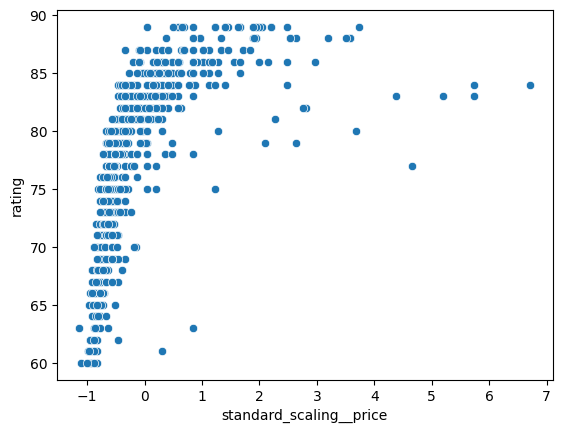

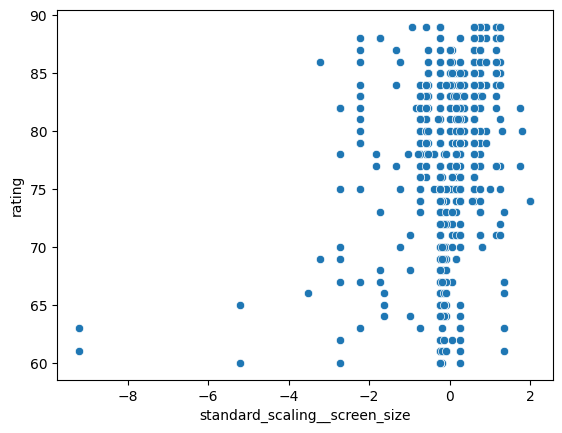

In [74]:
# relationship between target and all numerical columns
for col in columns_to_be_kept:
    sns.scatterplot(data=num_df[columns_to_be_kept].join(y_train, how='left'), x=col, y='rating')
    plt.show()

### Observations 

- Drop `standard_scaling__battery_capacity` due to multicollinearity.

### Categorical Columns

In [36]:
cat_cols_treated = Pipeline([
    ('handle_missing', missing_handler),
    ('feature_construction', feature_constructor),
    ('high_cardinality', FunctionTransformer(encode_features)),
    # ('feature_encoding', feature_encoder)  
])

In [37]:
cat_df = cat_cols_treated.fit_transform(X_train)

In [38]:
cat_df[nominal_cols + ordinal_cols]

,os,brand_name,processor_brand,extended_upto,has_5g,has_nfc,has_ir_blaster,num_cores,ram_capacity,internal_memory,fast_charging,resolution,refresh_rate,num_rear_cameras,primary_camera_rear,primary_camera_front,fast_charging_available,extended_memory_available
7,android,xiaomi,dimensity,no expansion,True,False,True,8.0,Standard,256.0,ultra fast,Full HD,120,3,extreme,standard,1,0
213,android,other,dimensity,large,True,False,False,8.0,Low,128.0,no,Quad HD,90,3,high-Resolution,basic,0,1
172,android,oppo,snapdragon,large,True,False,False,8.0,Standard,128.0,basic,Full HD,90,3,good,basic,1,1
357,android,poco,snapdragon,no expansion,True,True,False,8.0,High,256.0,ultra fast,Full HD,120,3,high-Resolution,good,1,0
112,android,xiaomi,dimensity,no expansion,True,False,True,8.0,Standard,128.0,ultra fast,Full HD,144,3,high-Resolution,standard,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,android,xiaomi,snapdragon,no expansion,True,True,True,8.0,Standard,128.0,ultra fast,Full HD,144,3,ultra-high,good,1,0
77,android,oppo,snapdragon,large,True,False,False,8.0,Standard,128.0,ultra fast,Full HD,120,3,high-Resolution,good,1,1
296,android,xiaomi,snapdragon,no expansion,True,True,True,8.0,Standard,128.0,ultra fast,Full HD,120,3,high-Resolution,good,1,0
496,android,realme,tiger,large,False,False,False,8.0,Low,32.0,no,HD Ready,60,3,standard,basic,0,1




--------------------------------------------os----------------------------------------------------------------------------------




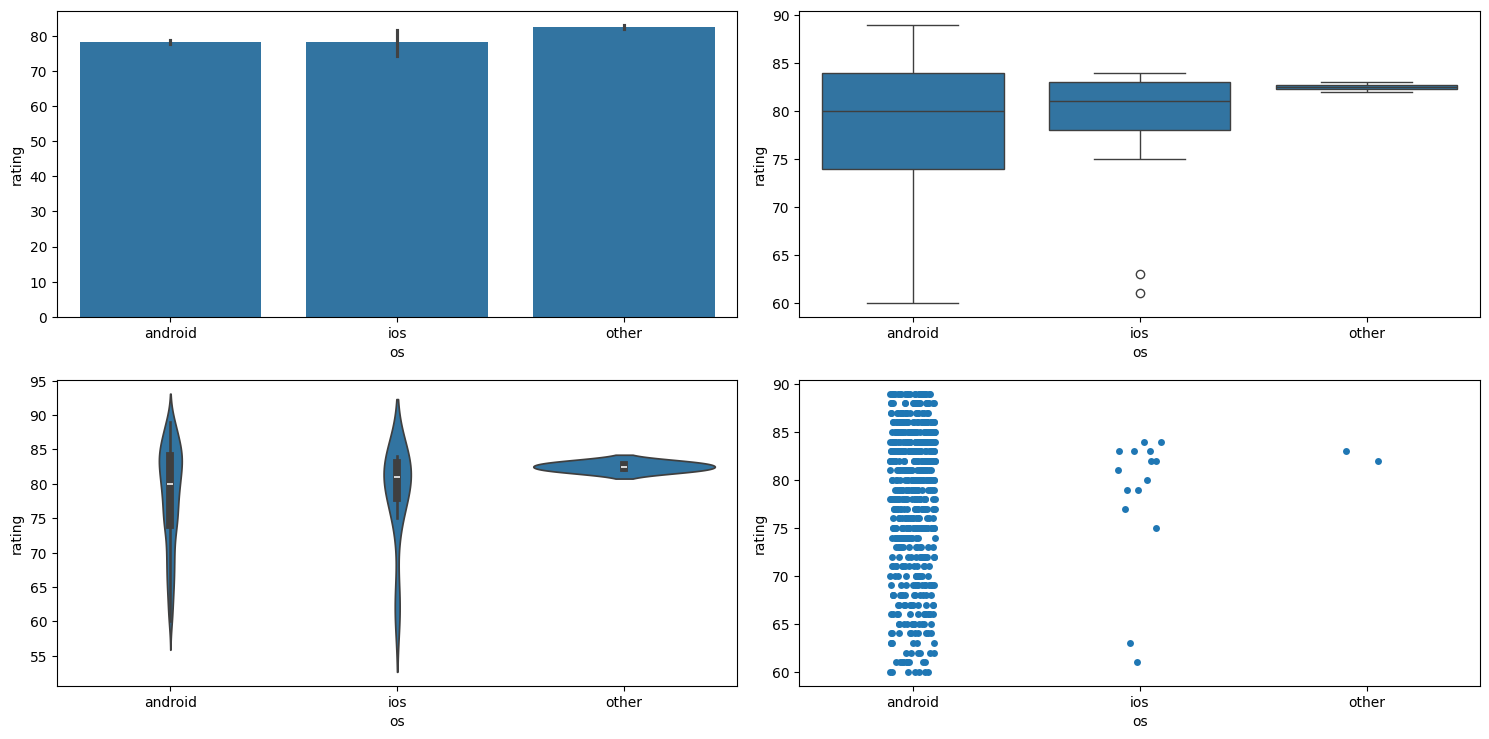

ANOVA p-value: 0.710829704003556
Fail to reject the null hypothesis. There is no significant relationship between rating and os.


--------------------------------------------brand_name----------------------------------------------------------------------------------




ANOVA p-value: 2.4680317841814413e-06
Reject the null hypothesis. There is a significant relationship between rating and brand_name.


--------------------------------------------processor_brand----------------------------------------------------------------------------------




ANOVA p-value: 2.9954078399542815e-68
Reject the null hypothesis. There is a significant relationship between rating and processor_brand.


--------------------------------------------extended_upto----------------------------------------------------------------------------------




ANOVA p-value: 6.340481187585734e-44
Reject the null hypothesis. There is a significant relationship between rating and extended_upto.


--------------------------------------------has_5g----------------------------------------------------------------------------------




T-statistic: 20.9483, p-value: 0.0000
Reject the null hypothesis. The means of rating differ between the two categories of has_5g.


--------------------------------------------has_nfc----------------------------------------------------------------------------------




T-statistic: -18.1610, p-value: 0.0000
Reject the null hypothesis. The means of rating differ between the two categories of has_nfc.


--------------------------------------------has_ir_blaster----------------------------------------------------------------------------------




T-statistic: 5.7594, p-value: 0.0000
Reject the null hypothesis. The means of rating differ between the two categories of has_ir_blaster.


--------------------------------------------num_cores----------------------------------------------------------------------------------




ANOVA p-value: 4.285651385375316e-10
Reject the null hypothesis. There is a significant relationship between rating and num_cores.


--------------------------------------------ram_capacity----------------------------------------------------------------------------------




ANOVA p-value: 7.951444608925093e-139
Reject the null hypothesis. There is a significant relationship between rating and ram_capacity.


--------------------------------------------internal_memory----------------------------------------------------------------------------------




ANOVA p-value: 1.3395566604044995e-131
Reject the null hypothesis. There is a significant relationship between rating and internal_memory.


--------------------------------------------fast_charging----------------------------------------------------------------------------------




ANOVA p-value: 2.917809462494765e-138
Reject the null hypothesis. There is a significant relationship between rating and fast_charging.


--------------------------------------------resolution----------------------------------------------------------------------------------




ANOVA p-value: 3.774196699688374e-110
Reject the null hypothesis. There is a significant relationship between rating and resolution.


--------------------------------------------refresh_rate----------------------------------------------------------------------------------




ANOVA p-value: 4.685295499620238e-80
Reject the null hypothesis. There is a significant relationship between rating and refresh_rate.


--------------------------------------------num_rear_cameras----------------------------------------------------------------------------------




ANOVA p-value: 4.540075298531279e-64
Reject the null hypothesis. There is a significant relationship between rating and num_rear_cameras.


--------------------------------------------primary_camera_rear----------------------------------------------------------------------------------




ANOVA p-value: 2.648648633321963e-90
Reject the null hypothesis. There is a significant relationship between rating and primary_camera_rear.


--------------------------------------------primary_camera_front----------------------------------------------------------------------------------




ANOVA p-value: 1.3103097268344217e-108
Reject the null hypothesis. There is a significant relationship between rating and primary_camera_front.


--------------------------------------------fast_charging_available----------------------------------------------------------------------------------




T-statistic: 24.0868, p-value: 0.0000
Reject the null hypothesis. The means of rating differ between the two categories of fast_charging_available.


--------------------------------------------extended_memory_available----------------------------------------------------------------------------------




T-statistic: 14.7845, p-value: 0.0000
Reject the null hypothesis. The means of rating differ between the two categories of extended_memory_available.


In [75]:
# relationship between target and all categorical columns
for col in nominal_cols + ordinal_cols:
    print("\n")
    print(f"--------------------------------------------{col}----------------------------------------------------------------------------------")
    print("\n")
    unique_categories = cat_df[nominal_cols + ordinal_cols].join(y_train, how='left')[col].nunique()
    numerical_categorical_analysis(cat_df[nominal_cols + ordinal_cols].join(y_train, how='left'), col, 'rating')
    if unique_categories >= 3:
        anova_test(cat_df[nominal_cols + ordinal_cols].join(y_train, how='left'), "rating", col)
    else:
        two_sample_independent_ttest(cat_df[nominal_cols + ordinal_cols].join(y_train, how='left'), "rating", col)
    


### Observations 

- Drop `os` as it not associated with rating.